##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to the Capital Asset Pricing Model (CAPM) and GLMs with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content created by Deepak Kanungo ([`deepak@hedgecapital.com`](mailto:deepak@hedgecapital.com)), Founder and CEO of Hedged Capital, an artificial intelligence powered trading and advisory firm.

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- [Dependencies & Prerequisites](#scrollTo=xR6ePAMgShcm)
- [Introduction: The Capital Asset Pricing Model](#scrollTo=T6KYm1lwwJyR)
- [More Detaill](#scrollTo=U7Q4uGpJQFjW)
- [Interpreting Beta](#scrollTo=Ur_up3hmjjBo)
- [Python Code for CAPM](#scrollTo=TM5jXAZtQFjI)
- [CAPM Model](#scrollTo=U7Q4uGpJQFjW)
- [Generalized Linear Models (and using them on Stock Data)](#scrollTo=XnYgxbealQCL)
- [GLMs with Tensorflow Probability](#scrollTo=JZU3grQhsBU5)
- [AAPL's Characteristic or Market Model (different from CAPM)](#scrollTo=RdAzw9pCQFjZ)
- [Creating a GLM for the entire S&P 500](#scrollTo=O6sP6Eule_4q)
- [Gathering the Data](#scrollTo=_7Ot5iEhp5jK)
- [Creating the Model for the S&P 500 stocks](#scrollTo=Hlqm7k56qEft)
- [Conclusion](#scrollTo=iwUCE4NkqQM-)
- [References](#scrollTo=m32FBZxDQFjd)



## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

!pip3 install -q pandas_datareader
!pip3 install -q wget

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
import bs4 as bs
import os
import pickle
import requests
import pandas as pd
from datetime import datetime
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = "fivethirtyeight" #@param ["fivethirtyeight", "bmh", "ggplot", "seaborn", "default", "Solarize_Light2", "classic", "dark_background", "seaborn-colorblind", "seaborn-notebook"]
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = "retina" #@param ["retina", "png", "jpeg", "svg", "pdf"]
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf                 # importing Tensorflow
import tensorflow_probability as tfp
tfd = tfp.distributions                 # Basic probability distribution toolkit
tfb = tfp.bijectors                     # Bijectors

# Eager Execution
tfe = tf.contrib.eager

#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_TF_Eager = False #@param {type:"boolean"}

#@markdown Visualizing the Tensorflow Graph with an in-cell Tensorboard window (currently only works in [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb), not standalone Jupyter notebook)
print_TF_graphs = False #@param {type:"boolean"}
# Use try/except so we can easily re-execute the whole notebook.
if use_TF_Eager == True:
    try:
        tf.enable_eager_execution()
    except:
        pass
else:
    pass

def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def strip_consts(graph_def, max_const_size=32):
    """
    Strip large constant values from graph_def.
    """
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
      n = strip_def.node.add()
      n.MergeFrom(n0)
      if n.op == 'Const':
        tensor = n.attr['value'].tensor
        size = len(tensor.tensor_content)
        if size > max_const_size:
          tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def


def draw_graph(model, *args, **kwargs):
    """
    Visualize TensorFlow graph.
    """
    graph = tf.Graph()
    with graph.as_default():
      model(*args, **kwargs)
    graph_def = graph.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=32)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    IPython.display.display(IPython.display.HTML(iframe))

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


## Introduction The Capital Asset Pricing Model

The **Capital Asset Pricing Model ($\text{CAPM} $)** is an economic equilibrium model that prices risky assets in efficient markets. 

According to $\text{CAPM} $, an asset has two types of risks: _unsystematic_ and _systematic_. Unsystematic risk is idiosyncratic and affects only the asset concerned. Systematic risk is market risk that affects all assets. 

Rational, risk-averse investors will hold only diversified portfolios that will reduce the correlation among assets and eliminate the idiosyncratic risk of any particular asset. Statistically, this implies that in a well diversified portfolio, the idiosyncratic risk of any particular asset will be zero as will the mean of any error term.

Therefore, such investors will be willing to pay a premium for only systematic risk of an asset, as it cannot be diversified away. The systematic risk of an asset is measured by its beta. An asset's beta gives the magnitude and direction of the movement of the asset with respect to the market (beta of the market portfolio $= 1$).


---

### The Formulation of $\text{CAPM} $

$\text{CAPM} $ formulates the expected return of an asset as a linear function of its systematic risk:

$$ \begin{align*}
E(R) &= R_f + B(E(R_m - R_f)) \end{align*} $$

Where:

$$ \begin{align*}
E(R) &= \text{Expected return of the asset} \end{align*} $$

$$ \begin{align*}
R_f &= \text{The risk free rate (We use the 4-week treasury bill).} \end{align*} $$

$$ \begin{align*}
R_m &= \text{Expect return of the market portfolio (We use S&P 500 index (SPY)).} \end{align*} $$

$$ \begin{align*}
B &= \frac{\text{Cov}(R, R_m)}{\text{Var}(R_m)} \text{, is called the asset's beta and measures its systematic risk} \end{align*} $$

To solve the equation above, we use arithmetic means of historical returns. For instance, an asset’s daily return:

$$ \begin{align*}
R &= \frac{(\text{today's closing price}) - (\text{yesterday's closing price})}{\text{yesterday's closing price}} \end{align*} $$

---

$\text{CAPM} $ states that the market portfolio that rational, risk averse investors hold needs to be a truly diversified portfolio of assets. Different indexes will give you different betas. While one can use any such aggregate index to calculate the beta of an asset, the industry standard is to use the S&P 500 index. 

The beta of an asset varies over time and changes with the holding time period of the returns used. The theory does not specify the holding period one should use. We can use any time period as long as it is used consistently throughout the formula. We use the daily time period because of its ease of calculation in Python. 


---


An asset's Market Model ($\text{MM} $) is a time series regression of the the realized excess returns of the asset against the realized excess returns of the market. Excess returns are defined as returns in excess of some benchmark such as the risk-free rate. 

Note that an asset's $\text{MM} $ is different from its $\text{CAPM} $. Unlike the $\text{CAPM} $, an asset's $\text{MM} $ has both an unsystematic risk term and an error term in its formulation. However, the beta of the asset is the same as the one calculated using the $\text{CAPM} $. 

According to the $\text{CAPM} $, the intercept, or alpha, of an asset's $\text{MM} $ is its realized excess return. The asset's realized postive/(negative) alpha shows that the market participants under priced/(overpiced) the security during the holding period since the intercept should actually be zero.

This implies that $\text{CAPM} $ and $\text{MM} $ can be used to evaluate a fund's performance. The difference between the realized return, calculated using its $\text{MM} $, and the expected return predicted by $\text{CAPM} $, is the alpha generated by the fund. This performance measure is called Jensen's Alpha.

---


**Data Sources:**

We use the following free data sources to get the daily closing prices of various assets [[1]]()[[2]]():

Risk free rate: https://fred.stlouisfed.org/series/TB4WK

Stock and market data: https://iextrading.com/developer/


## More Detail

Capital Asset Pricing Model (CAPM) is an extension of the Markowitz’s Modern Portfolio Theory. This model was developed by the independent works of William Sharpe, Jack Treynor, Jan Mossin, and John Lintner who built on the idea of diversification as introduced by the works of Harry Markowitz.

CAPM attempts to prices securities by examining the relationship that exists between expected returns and risk. The model implies that investors always combine two types of assets or securities; a risky free asset and a risky asset in the form of a market portfolio of various assets. CAPM further posits that investors expect to be rewarded for holding these risky assets according to the risk inherited for holding on to such assets. After all, such kind of risk cannot be diversified (market related usually referred to as systematic risk) and as a result, investors need to be compensated for taking on such “undiversifiable” risks. It is intuitive when you think about. Let’s look this example:

An investor can buy risk free asset like treasury bills of a stable central bank. If such an investor opts to buy some investment package from company ABC instead of this risk free assets, then such an investor ought to be compensated for this decision. According to CAPM, company ABC does by this by offering the returns of the treasury bill plus an incentive usually referred to as market premium/excess market returns (Market Return-Risk Free Rate) for the given level of risk (Beta) the investors take.

This is why it is common for most funds to advertise “Treasury Bill rate + XYZ%” to customers, which we will calculate below:

## Interpreting Beta

A stock with a beta of:

> **zero** indicates no correlation with the chosen benchmark (e.g. NASDAQ index )

> **one** indicates a stock has the same volatility as the market

>  **more than one** indicates a stock that’s more volatile than its benchmark

>  **less than one** is less volatile than the benchmark

>  **1.5** is 50% more volatile than the benchmark

# Python Code for CAPM

Great! Now that we have taken care of the theoretical aspects and explained the concept of Beta, let’s get our coding fingers dirty and make some calculations with Python! We'll start by calculating the risk-free rate, using TB4WK as our Benchmark.

/usr/local/lib/python3.6/dist-packages/pandas_datareader/fred.py:28: DeprecationWarning: pandas.core.common.is_list_like is deprecated. import from the public API: pandas.api.types.is_list_like instead
  return self._read()


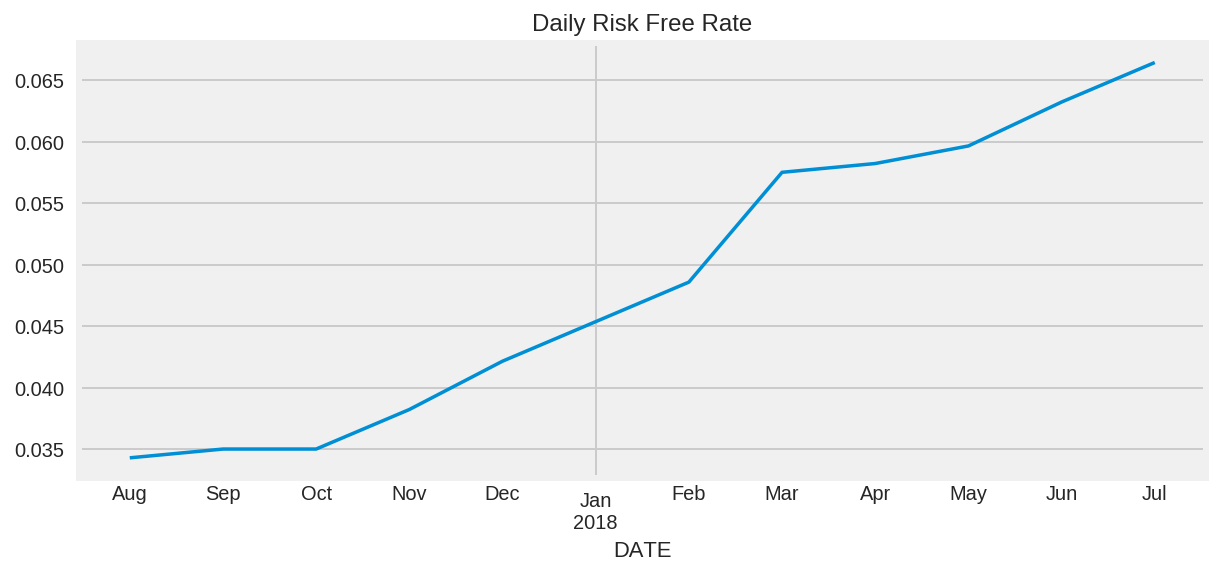

In [3]:
figsize(9, 4)

start = datetime(2017, 7, 16)
end = datetime(2018, 7, 17)

#riskfree_rate_benchmark = '^GSPC'  #@param ['TB4WK', '^GSPC']
riskfree_rate_benchmark = 'TB4WK'
riskfree_rate = web.DataReader(riskfree_rate_benchmark, 'fred', start, end)
riskfree_scaling = 28  # Need to scale the risk free rate by its maturity to get the daily risk free rate
riskfree_rate = riskfree_rate[riskfree_rate_benchmark].fillna(0)/riskfree_scaling
riskfree_rate.plot(),
plt.title('Daily Risk Free Rate'),
plt.show()

Now let's choose a market and stock to get the returns from. For the market and stock, let's go with SPY and Apple, respectively.

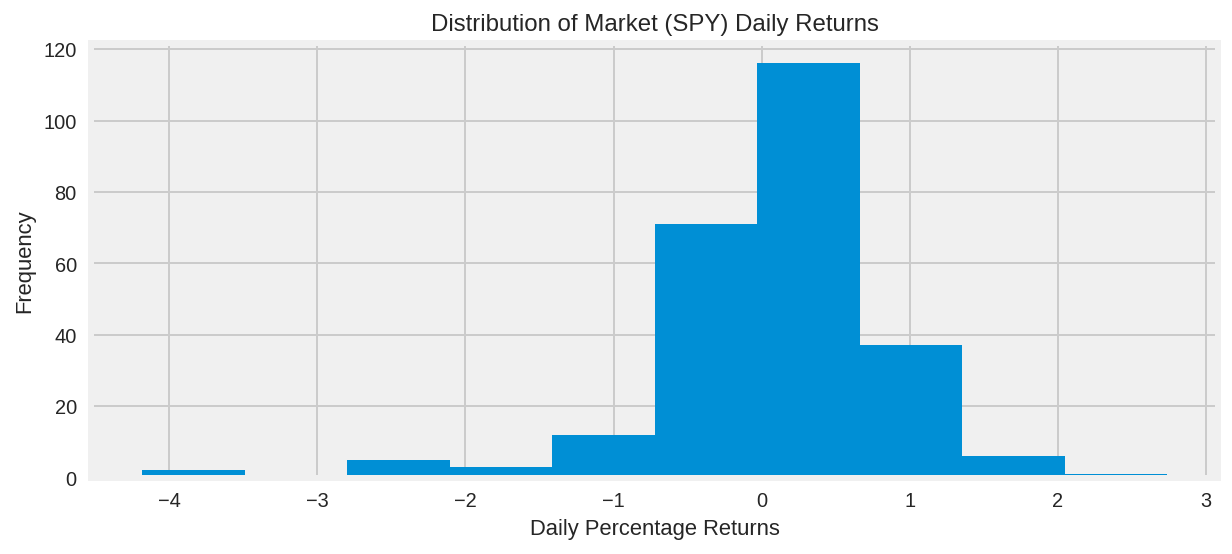

Descriptive Stastics of the Market's daily percentage returns:
count    253.000000
mean       0.063002
std        0.785897
min       -4.182252
25%       -0.204468
50%        0.092975
75%        0.404497
max        2.735882
Name: close, dtype: float64


In [4]:
market_choice = 'SPY' #@param ['SPY']
stock_choice = 'AAPL' #@param ['AAPL']

market = web.DataReader(market_choice, 'iex', start, end);
stock = web.DataReader(stock_choice, 'iex', start, end);

market_return = market['close'].pct_change(1) * 100
market_return = market_return.fillna(0)
plt.hist(market_return), 
plt.title('Distribution of Market (SPY) Daily Returns'), 
plt.xlabel('Daily Percentage Returns'), 
plt.ylabel('Frequency'), 
plt.show()
print("Descriptive Stastics of the Market's daily percentage returns:\n{}".format(market_return.describe()))

To get the distribution of stock returns, we'll select the column in the dataframe with the closing prices for each day.

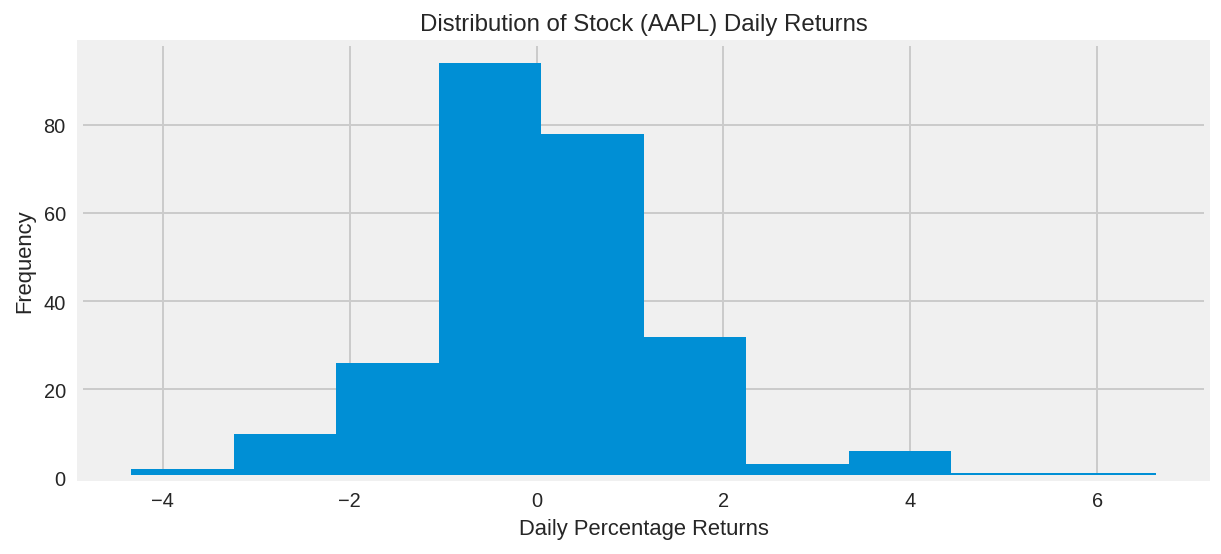

Descriptive stastics of Apple stock's percentage returns:
count    253.000000
mean       0.113199
std        1.381193
min       -4.339004
25%       -0.555202
50%        0.017614
75%        0.804698
max        6.629468
Name: close, dtype: float64


In [5]:
stock_return = stock['close'].pct_change(1)*100
stock_return = stock_return.fillna(0)
plt.hist(stock_return), 
plt.title('Distribution of Stock (AAPL) Daily Returns'), 
plt.xlabel('Daily Percentage Returns'), 
plt.ylabel('Frequency'), 
plt.show()
print("Descriptive stastics of Apple stock's percentage returns:\n{}".format(stock_return.describe()))

### CAPM Model

Good! Now that we have a clean set of monthly returns on Apple and S&P 500. Let’s go ahead and make the CAPM Model.

In [0]:
market_return_vals_ = market_return.values
stock_return_vals_ = stock_return.values
riskfree_rate_vals_ = riskfree_rate.values

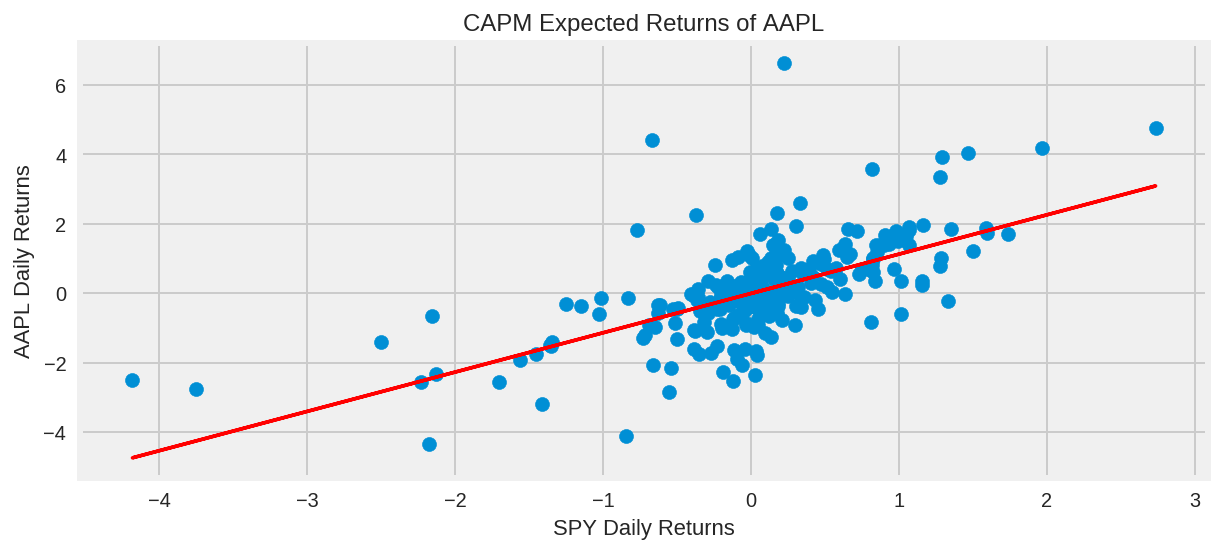

CAPM predicts that AAPL will have a daily average return of 0.065% with a daily average beta of 1.132



In [0]:
beta = market_return.cov(stock_return) / market_return.var()
expected_return = riskfree_rate.mean() + beta * (market_return.mean() - riskfree_rate.mean())

plt.scatter(market_return, stock_return), plt.title('CAPM Expected Returns of AAPL'), 
plt.xlabel('SPY Daily Returns'), 
plt.ylabel('AAPL Daily Returns')
plt.plot(market_return, (riskfree_rate.mean() + beta*(market_return - riskfree_rate.mean())), color = 'red'), 
plt.show()
print("CAPM predicts that AAPL will have a daily average return of {0}% with a daily average beta of {1}\n".format((round(expected_return, 3)), (round(beta,3))))

So with the CAPM model, we anticipate that `AAPL` will have a daily average return of `0.065%` with a daily average beta of `1.132`.  We can use a GLM to fit a similar model as well.

In [0]:
# We define our model
model=tfp.glm.Normal()

# Fit model given data.
coeffs, linear_response, is_converged, num_iter = tfp.glm.fit(
    model_matrix=tf.to_float(market_return_vals_)[:, tf.newaxis],
    response=tf.to_float(stock_return_vals_),
    model=model)

mean_linear_response = tf.reduce_mean(linear_response)
log_likelihood = -tf.reduce_mean(model.log_prob(tf.to_float(market_return_vals_)[:, tf.newaxis], linear_response))

In [30]:
[
    coeffs_, 
    linear_response_, 
    mean_linear_response_,
    is_converged_, 
    log_likelihood_,
    num_iter_
] = evaluate([
    coeffs, 
    linear_response, 
    mean_linear_response,
    is_converged, 
    log_likelihood,
    num_iter
])
print('        is_converged: ', is_converged_)
print('            num_iter: ', num_iter_)
print('      log_likelihood: ', log_likelihood_)
print('  daily average Beta: ', coeffs_)
print('daily average return: ', mean_linear_response_)

        is_converged:  True
            num_iter:  2
      log_likelihood:  1.6236106
  daily average Beta:  [1.1361244]
daily average return:  0.07157843


Based on our Generalized Linear model, we can expect a daily average Beta of ~1.136 (compare to 1.132 for Direct CAPM), and expected daily average returns of 0.071% (compare to 0.065% for Direct CAPM).

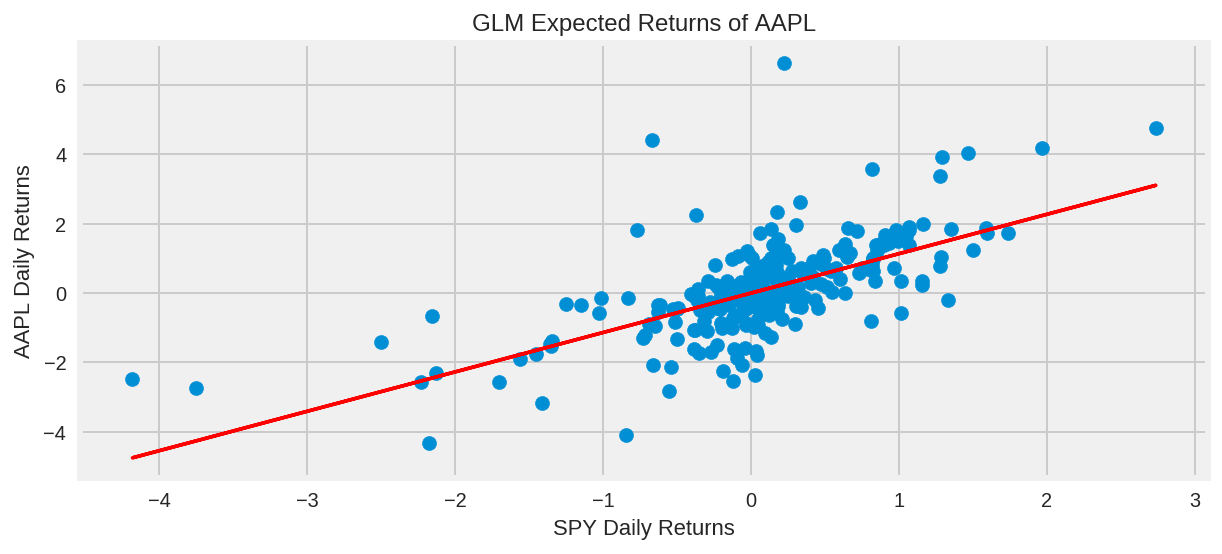

In [33]:
plt.scatter(market_return, stock_return), plt.title('GLM Expected Returns of AAPL'), 
plt.xlabel('SPY Daily Returns'), 
plt.ylabel('AAPL Daily Returns')
plt.plot(market_return, (riskfree_rate.mean() + coeffs_[0]*(market_return - riskfree_rate.mean())), color = 'red'), 
plt.show()

# Resources

1. Risk free rate: https://fred.stlouisfed.org/series/TB4WK
2. Stock and market data: https://iextrading.com/developer/